# Multivariate Time Series Prediction Using Transformers Architecture

The following Notebook shows the coding part of my Bachelor Thesis for the Information and Communication Systems and Services bachelor degree in the University of Applied Science Technikum Wien.

Author: Sergio Tallo Torres
Date: April 2022

# First: load imports needed for the project and project preparation

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 291 (delta 33), reused 6 (delta 1), pack-reused 226
Receiving objects: 100% (291/291), 13.03 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (172/172), done.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import statistics
import torch
import math
import sklearn
import scipy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from platform import python_version
from torch import Tensor, float32, sin, cos

import utils_bsc

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla K80


In [3]:

print('versions of packages:')
print(f'Python: {python_version()}')
print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'PyTorch: {torch.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'scipy: {scipy.__version__}')

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.11.0+cu113
Sklearn: 1.0.2
seaborn: 0.11.2
scipy: 1.4.1


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the value of the previous elemnt in the sequence).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False
print_graphs = False

In [7]:
if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [8]:
if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [9]:
# We print some graphs showing the density distribution of every feature
if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [10]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [11]:
if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [12]:
if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very different. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [13]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [14]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 528.78it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 579.96it/s]


In [16]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 265.63it/s]


In [17]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [18]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [19]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


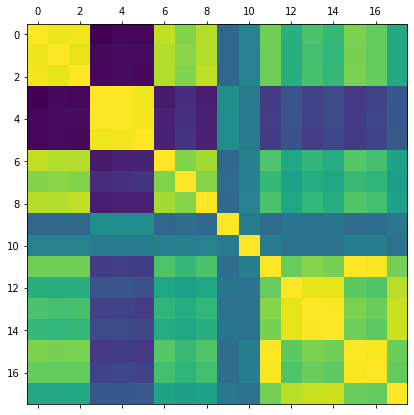

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810274, 0.16335739298653476, 0.07511546472382995, 0.054921627068028424, 0.05390616867076577, 0.04952232661739343, 0.022486349463995598, 0.013932731902136385, 0.012792662672300325, 0.009829012007199104, 0.004024926426955747, 0.002893959610103366, 0.002163271201445878, 0.001741116222641519, 0.0006928432299862775, 0.00021826337426103455, 0.00023351820917083064, 0.0004035851322244031]


In [20]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [21]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = stats.pearsonr(dataset_norm[i], dataset_norm[j])[0]
    if i != j:
      correlations.append(abs(correlation))
      feature.append(abs(correlation))
      print(correlation)
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686159
Correlation between PLN1 and PLN3
0.9606664987977853
Correlation between PLN1 and ULL1
-0.727401637634178
Correlation between PLN1 and ULL2
-0.69552822775147
Correlation between PLN1 and ULL3
-0.7030835410050382
Correlation between PLN1 and COS_PHI1
0.8410401295195358
Correlation between PLN1 and COS_PHI2
0.6731338062873109
Correlation between PLN1 and COS_PHI3
0.8122370309192148
Correlation between PLN1 and FREQ
-0.1545159794969927
Correlation between PLN1 and RC_DC
0.04144790238090617
Correlation between PLN1 and RC_AC
0.6311099014117807
Correlation between PLN1 and RC_50Hz
0.3688113546135111
Correlation between PLN1 and RC_150Hz
0.5078743784519384
Correlation between PLN1 and RC_<100Hz
0.4309325330867661
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453893
Correlation between PLN1 and RC_>1kHz
0.5928797475823844
Correlation between PLN1 and RC_>10kHz
0.3161918341465537
Mean of PLN1 correl

In [22]:
# Covariance matrix, eigenvalues and explained variance

covmatrix = dataset_norm.cov()
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

acc = 0

for i, eigen in enumerate(eigenvalues):
  acc += eigen/np.sum(eigenvalues)
  print(f'Explained_variance {i +1} principal component: {eigen/np.sum(eigenvalues)} (accumulated {round(acc, 4)})')

Explained_variance 1 principal component: 0.5317647804810274 (accumulated 0.5318)
Explained_variance 2 principal component: 0.16335739298653476 (accumulated 0.6951)
Explained_variance 3 principal component: 0.07511546472382995 (accumulated 0.7702)
Explained_variance 4 principal component: 0.054921627068028424 (accumulated 0.8252)
Explained_variance 5 principal component: 0.05390616867076577 (accumulated 0.8791)
Explained_variance 6 principal component: 0.04952232661739343 (accumulated 0.9286)
Explained_variance 7 principal component: 0.022486349463995598 (accumulated 0.9511)
Explained_variance 8 principal component: 0.013932731902136385 (accumulated 0.965)
Explained_variance 9 principal component: 0.012792662672300325 (accumulated 0.9778)
Explained_variance 10 principal component: 0.009829012007199104 (accumulated 0.9876)
Explained_variance 11 principal component: 0.004024926426955747 (accumulated 0.9917)
Explained_variance 12 principal component: 0.002893959610103366 (accumulated 0.99

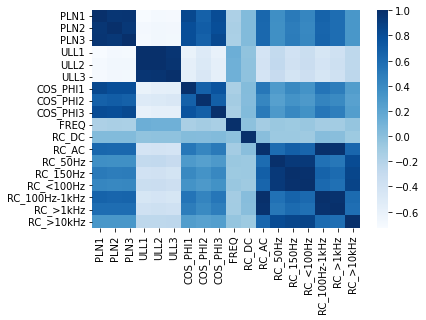

In [23]:
# Features correlations heat map

corr = dataset_norm.corr()
sns.heatmap(corr, cmap="Blues")

# Data loaders for the training

In [24]:
def create_sequece_dataloaders_new(dataset_norm, seq_length, batch_size):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of seq_length measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  assert seq_length > 1, f"sequence length should be greater than 1 expected, got: {seq_length}"

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - (seq_length +1))):    
    data = np.array(dataset_norm.iloc[i:i+seq_length, 1:])
    next = np.array(dataset_norm.iloc[i+seq_length, 1:], dtype= float)
    target = np.array(dataset_norm.iloc[i+(seq_length + 1), 1:], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=batch_size,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=batch_size,
      shuffle=True
  )

  return loader_train, loader_test

In [25]:
loader_train_seq, loader_test_seq = create_sequece_dataloaders_new(dataset_norm, 30, 16)

100%|██████████| 63329/63329 [01:34<00:00, 673.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56996
length of test set (whole dataset): 6333




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [26]:
def create_dataloaders_new(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=16,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=16,
      shuffle=True
  )

  return loader_train, loader_test

In [27]:
loader_train, loader_test = create_dataloaders_new(dataset_norm)

100%|██████████| 63359/63359 [00:38<00:00, 1628.06it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [28]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

# save to npy file
if False:
  np.save('baseline_train.npy', losses_train)
  np.save('baseline_test.npy', losses_test)

Training set
Mean Loss of baselinemodel:  0.47168113485053936
Standard deviation Loss of baselinemodel:  0.17687419475447555


Test set
Mean Loss of baselinemodel:  0.48489113562185354
Standard deviation Loss of baselinemodel:  0.18444396158205617




In [29]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [31]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN = ANN_relu(18, 18).to(device)
print(model_FFN)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN.parameters(), lr=lr)


train_FFN = False

params_not_trained_whole = model_FFN.parameters()

start_time = datetime.now()
if train_FFN is True:
  trained_model_FFN , train_losses_FFN, test_losses_FFN = train(model_FFN, criterion, optimizer_whole, loader_train, loader_test, n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'\nTraining time: {execution_time} seconds')

# save to npy file
if True:
  np.save('FFN_train.npy', losses_train)
  np.save('FFN_test.npy', losses_test)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Training time: 0.000141 seconds


In [ ]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_FFN))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_FFN], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

#min values in numpy array
minval = np.amin([np.mean(i) for i in test_losses_FFN])
print('min value in array:',minval)
indice = np.where([np.mean(i) for i in test_losses_FFN] == np.amin([np.mean(i) for i in test_losses_FFN]))
print('min value index:',indice[0])

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [32]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(self, seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)

        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        position_encoding = position_encoding.to(device)

        return position_encoding
        
    def forward (self, enc_input, dec_input):
        
        memory_mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src= src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=None, memory_mask=None)
        
        return output

In [33]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [34]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_1, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if False:
  np.save('Transformer_Vanilla_train.npy', train_losses_1)
  np.save('Transformer_Vanilla_test.npy', test_losses_1)

Setup model Ok
Setup optimizer Ok
Training time: 0.021089 seconds


In [28]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_FFN], label= 'Train Loss Baseline model')

  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = False

if train_transformer is True:
  trained_model_transformer_2, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if train_transformer is True:
  np.save('Transformer_ADAM_train.npy', train_losses_2)
  np.save('Transformer_ADAM_test.npy', test_losses_2)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.32it/s]



Current Mean loss Train Set:  0.343332271336037

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.00it/s]



Current Mean loss Test Set:  0.35316876826262233


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.64it/s]



Current Mean loss Train Set:  0.33278762570700215

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.26it/s]



Current Mean loss Test Set:  0.34172109540815304


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.3407313210841079

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.83it/s]



Current Mean loss Test Set:  0.3513083467354076


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.73it/s]



Current Mean loss Train Set:  0.3254669357594097

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.3354614887273673


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.44it/s]



Current Mean loss Train Set:  0.31997127458766844

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.62it/s]



Current Mean loss Test Set:  0.3308199236940856


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.46it/s]



Current Mean loss Train Set:  0.31888518949597866

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.10it/s]



Current Mean loss Test Set:  0.3302124244621908


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.3238143402808107

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.61it/s]



Current Mean loss Test Set:  0.33420385619757154


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.73it/s]



Current Mean loss Train Set:  0.32300676727249755

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.41it/s]



Current Mean loss Test Set:  0.3341891837466245


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.318523274540667

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.08it/s]



Current Mean loss Test Set:  0.32865313749120695


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.3169663311673656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.37it/s]



Current Mean loss Test Set:  0.3276424956592647


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.38it/s]



Current Mean loss Train Set:  0.31710132917401296

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.74it/s]



Current Mean loss Test Set:  0.32742879765503335


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.32006085023948927

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.61it/s]



Current Mean loss Test Set:  0.33115795288573613


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.91it/s]



Current Mean loss Train Set:  0.31587105868590737

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.38it/s]



Current Mean loss Test Set:  0.326168610968373


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.76it/s]



Current Mean loss Train Set:  0.31712680163843193

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.53it/s]



Current Mean loss Test Set:  0.32814623411707206


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.72it/s]



Current Mean loss Train Set:  0.3149726485356233

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.72it/s]



Current Mean loss Test Set:  0.3253659799205835


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.61it/s]



Current Mean loss Train Set:  0.31455217664650975

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.01it/s]



Current Mean loss Test Set:  0.3244328885292164


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.71it/s]



Current Mean loss Train Set:  0.31229536604411207

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.87it/s]



Current Mean loss Test Set:  0.3220124240362584


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.56it/s]



Current Mean loss Train Set:  0.31589881056167424

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.52it/s]



Current Mean loss Test Set:  0.32545812586040207


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.45it/s]



Current Mean loss Train Set:  0.3116207127403149

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.06it/s]



Current Mean loss Test Set:  0.32196356107791263


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.56it/s]



Current Mean loss Train Set:  0.3125416757374241

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.80it/s]



Current Mean loss Test Set:  0.32267269405602206


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 124.02it/s]



Current Mean loss Train Set:  0.3129099209950006

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.22it/s]



Current Mean loss Test Set:  0.32292706380137287


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.58it/s]



Current Mean loss Train Set:  0.31353787369158304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.08it/s]



Current Mean loss Test Set:  0.32426241879360845


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.63it/s]



Current Mean loss Train Set:  0.3148621747914807

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.44it/s]



Current Mean loss Test Set:  0.3252480100802701


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.75it/s]



Current Mean loss Train Set:  0.3127441458882926

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.11it/s]



Current Mean loss Test Set:  0.3228972533510791


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.08it/s]



Current Mean loss Train Set:  0.3154770619968601

Test with test set


100%|██████████| 396/396 [00:03<00:00, 126.51it/s]



Current Mean loss Test Set:  0.32631884293273244


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.66it/s]



Current Mean loss Train Set:  0.3144227001934181

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.13it/s]



Current Mean loss Test Set:  0.32445480373471675


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.14it/s]



Current Mean loss Train Set:  0.3137110849837724

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.07it/s]



Current Mean loss Test Set:  0.32333571493926677


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.66it/s]



Current Mean loss Train Set:  0.3114800138914983

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.33it/s]



Current Mean loss Test Set:  0.3216697286174755


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.37it/s]



Current Mean loss Train Set:  0.31160782549008537

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.03it/s]



Current Mean loss Test Set:  0.3222882695910003


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.57it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.67it/s]



Current Mean loss Train Set:  0.31708116406784476

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.41it/s]



Current Mean loss Test Set:  0.32761181394259137


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.26it/s]



Current Mean loss Train Set:  0.3113830541748028

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.49it/s]



Current Mean loss Test Set:  0.32193089528667806


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.95it/s]



Current Mean loss Train Set:  0.31140180606705536

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.38it/s]



Current Mean loss Test Set:  0.32160377201407847


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.91it/s]



Current Mean loss Train Set:  0.31013544411127936

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.63it/s]



Current Mean loss Test Set:  0.32066143744371156


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.54it/s]



Current Mean loss Train Set:  0.3101622323570143

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.74it/s]



Current Mean loss Test Set:  0.32043696734866106


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.94it/s]



Current Mean loss Train Set:  0.3105396485996989

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.56it/s]



Current Mean loss Test Set:  0.3201812467340267


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.60it/s]



Current Mean loss Train Set:  0.311297954956434

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.06it/s]



Current Mean loss Test Set:  0.3214085193896534


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.74it/s]



Current Mean loss Train Set:  0.31301269235694273

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.45it/s]



Current Mean loss Test Set:  0.32345049790661745


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.27it/s]



Current Mean loss Train Set:  0.3126849160832098

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.34it/s]



Current Mean loss Test Set:  0.3225358673042119


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.67it/s]



Current Mean loss Train Set:  0.31380694610054427

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.43it/s]



Current Mean loss Test Set:  0.32512452867296004


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.70it/s]



Current Mean loss Train Set:  0.3077362768232839

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.42it/s]



Current Mean loss Test Set:  0.3180246554465607


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.31178284071776896

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.51it/s]



Current Mean loss Test Set:  0.32205886858506033


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.11it/s]



Current Mean loss Train Set:  0.3129271581756443

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.00it/s]



Current Mean loss Test Set:  0.3231283419323389


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.15it/s]



Current Mean loss Train Set:  0.3110722479711849

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.01it/s]



Current Mean loss Test Set:  0.321499690977913


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.96it/s]



Current Mean loss Train Set:  0.30942170478355474

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.3193258692632721


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.52it/s]



Current Mean loss Train Set:  0.3102597847137597

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.69it/s]



Current Mean loss Test Set:  0.3204522473417749


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.65it/s]



Current Mean loss Train Set:  0.30995186708748357

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.91it/s]



Current Mean loss Test Set:  0.32038779530410816


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.90it/s]



Current Mean loss Train Set:  0.30883662240778903

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.17it/s]



Current Mean loss Test Set:  0.31869226332866785


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.41it/s]



Current Mean loss Train Set:  0.3131074937305657

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.20it/s]



Current Mean loss Test Set:  0.32323838486289136


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.05it/s]



Current Mean loss Train Set:  0.3086100014895326

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.85it/s]



Current Mean loss Test Set:  0.3188903159414879


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.71it/s]



Current Mean loss Train Set:  0.3118686099384328

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.19it/s]



Current Mean loss Test Set:  0.3222780359739607


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.26it/s]



Current Mean loss Train Set:  0.3079077758181473

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.61it/s]



Current Mean loss Test Set:  0.31879771711549376


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.41it/s]



Current Mean loss Train Set:  0.3130102086620922

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.65it/s]



Current Mean loss Test Set:  0.3229511249622311


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.08it/s]



Current Mean loss Train Set:  0.30963290746446875

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.42it/s]



Current Mean loss Test Set:  0.31968282102936446


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.31069923170306124

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.34it/s]



Current Mean loss Test Set:  0.32082978543834856


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.06it/s]



Current Mean loss Train Set:  0.31036423767571564

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.66it/s]



Current Mean loss Test Set:  0.32061227234174505


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.00it/s]



Current Mean loss Train Set:  0.307492954913164

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.30it/s]



Current Mean loss Test Set:  0.31800631663263446


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.59it/s]



Current Mean loss Train Set:  0.3094398255825645

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.17it/s]



Current Mean loss Test Set:  0.31917472887370324


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.76it/s]



Current Mean loss Train Set:  0.3116609002310608

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.24it/s]



Current Mean loss Test Set:  0.32193998992443085


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.36it/s]



Current Mean loss Train Set:  0.3104845860279279

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.32135460145696243


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.28it/s]



Current Mean loss Train Set:  0.3095125950331304

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.41it/s]



Current Mean loss Test Set:  0.31906330226120927


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.02it/s]



Current Mean loss Train Set:  0.3130526327949677

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.28it/s]



Current Mean loss Test Set:  0.324416638229682


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.24it/s]



Current Mean loss Train Set:  0.3098816022803835

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.26it/s]



Current Mean loss Test Set:  0.3199196756074224


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.36it/s]



Current Mean loss Train Set:  0.30734982487695656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.69it/s]



Current Mean loss Test Set:  0.31835273062490455


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.65it/s]



Current Mean loss Train Set:  0.31306208008516045

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.85it/s]



Current Mean loss Test Set:  0.3243953061826301


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.16it/s]



Current Mean loss Train Set:  0.3093421722069872

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.75it/s]



Current Mean loss Test Set:  0.32014999877322803


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.17it/s]



Current Mean loss Train Set:  0.3098706059239401

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.07it/s]



Current Mean loss Test Set:  0.32108422195670583


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.3081578738818067

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.91it/s]



Current Mean loss Test Set:  0.31848450814082163


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.42it/s]



Current Mean loss Train Set:  0.3094854420393396

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.82it/s]



Current Mean loss Test Set:  0.31997348326775765


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.97it/s]



Current Mean loss Train Set:  0.31399456640784407

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.22it/s]



Current Mean loss Test Set:  0.32488214457877956


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.53it/s]



Current Mean loss Train Set:  0.3090180446559246

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.74it/s]



Current Mean loss Test Set:  0.319733469718785


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.50it/s]



Current Mean loss Train Set:  0.30993251665201277

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.17it/s]



Current Mean loss Test Set:  0.32009205276692154


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.16it/s]



Current Mean loss Train Set:  0.30667825131445764

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.55it/s]



Current Mean loss Test Set:  0.3163149016297827


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.70it/s]



Current Mean loss Train Set:  0.3073985877559488

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.92it/s]



Current Mean loss Test Set:  0.31837911478648284


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.74it/s]



Current Mean loss Train Set:  0.31093560805355536

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.89it/s]



Current Mean loss Test Set:  0.32135715333726067


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.91it/s]



Current Mean loss Train Set:  0.3091190281169086

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.07it/s]



Current Mean loss Test Set:  0.3198858711003053


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.67it/s]



Current Mean loss Train Set:  0.3080524738073985

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.49it/s]



Current Mean loss Test Set:  0.3200844289979549


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.10it/s]



Current Mean loss Train Set:  0.31434266373552766

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.78it/s]



Current Mean loss Test Set:  0.32543007160226506


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.41it/s]



Current Mean loss Train Set:  0.30819973413349705

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.47it/s]



Current Mean loss Test Set:  0.31924782253124495


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.23it/s]



Current Mean loss Train Set:  0.3087925315070547

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.42it/s]



Current Mean loss Test Set:  0.31936737736969284


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.3087454229831662

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.65it/s]



Current Mean loss Test Set:  0.31956218672220155


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.15it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.30800718270658345

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.31842352995517276


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.10it/s]



Current Mean loss Train Set:  0.3099802702920443

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.44it/s]



Current Mean loss Test Set:  0.32049151336905934


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.70it/s]



Current Mean loss Train Set:  0.3102884487848318

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.50it/s]



Current Mean loss Test Set:  0.3203900008641108


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.86it/s]



Current Mean loss Train Set:  0.309295963940328

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.76it/s]



Current Mean loss Test Set:  0.31958474512353086


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.72it/s]



Current Mean loss Train Set:  0.308166836227656

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.69it/s]



Current Mean loss Test Set:  0.31970158283307093


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.27it/s]



Current Mean loss Train Set:  0.31134013614350414

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.46it/s]



Current Mean loss Test Set:  0.3217942546112369


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.87it/s]



Current Mean loss Train Set:  0.30848061735630705

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.82it/s]



Current Mean loss Test Set:  0.31868592510470234


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.87it/s]



Current Mean loss Train Set:  0.31187982300786266

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.26it/s]



Current Mean loss Test Set:  0.3223462350139714


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 122.93it/s]



Current Mean loss Train Set:  0.31118749950939506

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.71it/s]



Current Mean loss Test Set:  0.32218922386792576


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.74it/s]



Current Mean loss Train Set:  0.31103425439099

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.90it/s]



Current Mean loss Test Set:  0.32207531781133375


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.16it/s]



Current Mean loss Train Set:  0.3081671134528236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.39it/s]



Current Mean loss Test Set:  0.3187977098342445


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.3086395646196351

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.52it/s]



Current Mean loss Test Set:  0.3193924373034576


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.36it/s]



Current Mean loss Train Set:  0.3078029568074728

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.71it/s]



Current Mean loss Test Set:  0.31875145307393987


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.42it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.09it/s]



Current Mean loss Train Set:  0.3070871094986692

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.12it/s]



Current Mean loss Test Set:  0.31889040820827386


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.92it/s]



Current Mean loss Train Set:  0.30940525326590307

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.62it/s]



Current Mean loss Test Set:  0.3188233830109991


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.41it/s]



Current Mean loss Train Set:  0.309443062745869

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.05it/s]



Current Mean loss Test Set:  0.320125713342368


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.44it/s]



Current Mean loss Train Set:  0.3103767316427721

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.75it/s]



Current Mean loss Test Set:  0.320593878927857


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.84it/s]



Current Mean loss Train Set:  0.3075179670559132

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.04it/s]



Current Mean loss Test Set:  0.3183668093624139


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.44it/s]



Current Mean loss Train Set:  0.30808114822731236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.59it/s]



Current Mean loss Test Set:  0.31877210977101567


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.86it/s]



Current Mean loss Train Set:  0.30541635445629384

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.26it/s]



Current Mean loss Test Set:  0.3163244209130003


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.17it/s]



Current Mean loss Train Set:  0.308413180194057

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.83it/s]



Current Mean loss Test Set:  0.3192445719708698


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.81it/s]



Current Mean loss Train Set:  0.30457878029567287

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.87it/s]



Current Mean loss Test Set:  0.3142799005815477


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.97it/s]



Current Mean loss Train Set:  0.3095480769584094

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.63it/s]



Current Mean loss Test Set:  0.3205003251293392


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.20it/s]



Current Mean loss Train Set:  0.30977007088837183

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.47it/s]



Current Mean loss Test Set:  0.3204616367666408


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.01it/s]



Current Mean loss Train Set:  0.30678059174510625

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.15it/s]



Current Mean loss Test Set:  0.3178891291597275


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:28<00:00, 123.23it/s]



Current Mean loss Train Set:  0.3084771113970492

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.63it/s]



Current Mean loss Test Set:  0.3194240896840288


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.99it/s]



Current Mean loss Train Set:  0.30797961319752565

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.46it/s]



Current Mean loss Test Set:  0.317476324737072


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.78it/s]



Current Mean loss Train Set:  0.31068928423278824

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.04it/s]



Current Mean loss Test Set:  0.3222486637344565


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.68it/s]



Current Mean loss Train Set:  0.30998331602373186

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.52it/s]



Current Mean loss Test Set:  0.32056944807897314


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.42it/s]



Current Mean loss Train Set:  0.3101030629762866

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.21it/s]



Current Mean loss Test Set:  0.3206740896208118


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.53it/s]



Current Mean loss Train Set:  0.309746929347398

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.01it/s]



Current Mean loss Test Set:  0.3209691770525292


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.43it/s]



Current Mean loss Train Set:  0.30746760568339737

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.88it/s]



Current Mean loss Test Set:  0.3181701978348722


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.75it/s]



Current Mean loss Train Set:  0.30765214401610674

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.72it/s]



Current Mean loss Test Set:  0.31868083188028046


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.03it/s]



Current Mean loss Train Set:  0.30929640691425236

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.19it/s]



Current Mean loss Test Set:  0.3201463741786552


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.97it/s]



Current Mean loss Train Set:  0.3068556033332061

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.32it/s]



Current Mean loss Test Set:  0.3169552730490463


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.49it/s]



Current Mean loss Train Set:  0.30592340220277175

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.25it/s]



Current Mean loss Test Set:  0.31704974065374847


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.31it/s]



Current Mean loss Train Set:  0.30854866111877427

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.31it/s]



Current Mean loss Test Set:  0.3185872780253189


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.90it/s]



Current Mean loss Train Set:  0.30774857163839114

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.31720018744318174


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.29it/s]



Current Mean loss Train Set:  0.30841384204943595

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.38it/s]



Current Mean loss Test Set:  0.31934640349613297


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.82it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.84it/s]



Current Mean loss Train Set:  0.3087591726626702

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.36it/s]



Current Mean loss Test Set:  0.3194575166198039


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.26it/s]



Current Mean loss Train Set:  0.30525414845789883

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.52it/s]



Current Mean loss Test Set:  0.3159546541294666


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.52it/s]



Current Mean loss Train Set:  0.3097841122257987

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.76it/s]



Current Mean loss Test Set:  0.32117943488287204


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.35it/s]



Current Mean loss Train Set:  0.31174637305537467

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.323074828720454


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.19it/s]



Current Mean loss Train Set:  0.3056970415676105

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.80it/s]



Current Mean loss Test Set:  0.31610447042292417


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.14it/s]



Current Mean loss Train Set:  0.3093205313087179

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.85it/s]



Current Mean loss Test Set:  0.31962251448721596


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.14it/s]



Current Mean loss Train Set:  0.3064678884162315

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.07it/s]



Current Mean loss Test Set:  0.3176280942867802


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.55it/s]



Current Mean loss Train Set:  0.308403543824732

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.15it/s]



Current Mean loss Test Set:  0.31881621583468384


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.44it/s]



Current Mean loss Train Set:  0.30527456463796854

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.34it/s]



Current Mean loss Test Set:  0.31619023162909227


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.3044701257499456

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.07it/s]



Current Mean loss Test Set:  0.31481649824465163


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.24it/s]



Current Mean loss Train Set:  0.3097011885769642

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.53it/s]



Current Mean loss Test Set:  0.3200173864536213


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.30587307877113

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.86it/s]



Current Mean loss Test Set:  0.3163185419909882


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.30605262077962153

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.24it/s]



Current Mean loss Test Set:  0.31627550525496706


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.24it/s]



Current Mean loss Train Set:  0.30768752503338204

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.30it/s]



Current Mean loss Test Set:  0.3178499847876303


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.3067768241079912

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.44it/s]



Current Mean loss Test Set:  0.3177285801355887


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.48it/s]



Current Mean loss Train Set:  0.30591830688808663

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.08it/s]



Current Mean loss Test Set:  0.3167640682723787


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.07it/s]



Current Mean loss Train Set:  0.30639765172602923

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.72it/s]



Current Mean loss Test Set:  0.3168323576412719


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.30it/s]



Current Mean loss Train Set:  0.30706086099658025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.55it/s]



Current Mean loss Test Set:  0.3173651075498624


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.06it/s]



Current Mean loss Train Set:  0.3093712633387312

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.50it/s]



Current Mean loss Test Set:  0.31992723802198664


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.15it/s]



Current Mean loss Train Set:  0.3067575636168996

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.59it/s]



Current Mean loss Test Set:  0.31734116119567796


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.39it/s]



Current Mean loss Train Set:  0.31049017539159524

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.29it/s]



Current Mean loss Test Set:  0.3209244024309546


Epoch: 141 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 118.93it/s]



Current Mean loss Train Set:  0.30897626288103447

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.71it/s]



Current Mean loss Test Set:  0.31989670401871806


Epoch: 142 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.70it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.91it/s]



Current Mean loss Train Set:  0.3067809118670491

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.77it/s]



Current Mean loss Test Set:  0.31801862457785945


Epoch: 143 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.02it/s]



Current Mean loss Train Set:  0.306958708984277

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.88it/s]



Current Mean loss Test Set:  0.3170823171132743


Epoch: 144 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.46it/s]



Current Mean loss Train Set:  0.308081456662111

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.42it/s]



Current Mean loss Test Set:  0.3186568175677699


Epoch: 145 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.51it/s]



Current Mean loss Train Set:  0.3085616363310225

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.31846201395371343


Epoch: 146 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.39it/s]



Current Mean loss Train Set:  0.3071598601021728

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.66it/s]



Current Mean loss Test Set:  0.3179976599987107


Epoch: 147 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.59it/s]



Current Mean loss Train Set:  0.30749788992849253

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.75it/s]



Current Mean loss Test Set:  0.31861468573862856


Epoch: 148 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.91it/s]



Current Mean loss Train Set:  0.3059978928587392

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.77it/s]



Current Mean loss Test Set:  0.3158948914044433


Epoch: 149 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.23it/s]



Current Mean loss Train Set:  0.3103756958468724

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.21it/s]



Current Mean loss Test Set:  0.3213540157397287


Epoch: 150 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.30973988934962426

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.83it/s]



Current Mean loss Test Set:  0.3210854351972089


Epoch: 151 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.41it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 117.94it/s]



Current Mean loss Train Set:  0.3052237824822556

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.31it/s]



Current Mean loss Test Set:  0.31650786120632685


Epoch: 152 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.07it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 117.62it/s]



Current Mean loss Train Set:  0.30566717844028807

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.93it/s]



Current Mean loss Test Set:  0.3158872125651499


Epoch: 153 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 118.31it/s]



Current Mean loss Train Set:  0.30910018794269933

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.06it/s]



Current Mean loss Test Set:  0.31859178457296256


Epoch: 154 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.18it/s]



Current Mean loss Train Set:  0.30447894222710264

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.28it/s]



Current Mean loss Test Set:  0.3151298735403653


Epoch: 155 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.08it/s]



Current Mean loss Train Set:  0.30963649298371543

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.67it/s]



Current Mean loss Test Set:  0.3206858799764604


Epoch: 156 of 200
Training...


100%|██████████| 3563/3563 [01:43<00:00, 34.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.02it/s]



Current Mean loss Train Set:  0.3081669900927054

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.14it/s]



Current Mean loss Test Set:  0.3188507067547603


Epoch: 157 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.76it/s]



Current Mean loss Train Set:  0.3082117947164025

Test with test set


100%|██████████| 396/396 [00:03<00:00, 124.89it/s]



Current Mean loss Test Set:  0.31844685271833884


Epoch: 158 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.83it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.22it/s]



Current Mean loss Train Set:  0.3060300762114517

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.74it/s]



Current Mean loss Test Set:  0.31600611779199106


Epoch: 159 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.36it/s]



Current Mean loss Train Set:  0.3053894799590579

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.35it/s]



Current Mean loss Test Set:  0.31632602512083874


Epoch: 160 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.15it/s]



Current Mean loss Train Set:  0.30890159296363784

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.82it/s]



Current Mean loss Test Set:  0.320123764074812


Epoch: 161 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.97it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.84it/s]



Current Mean loss Train Set:  0.3108280745849595

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.87it/s]



Current Mean loss Test Set:  0.3203912852990507


Epoch: 162 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.55it/s]



Current Mean loss Train Set:  0.3087331774635928

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.46it/s]



Current Mean loss Test Set:  0.3188391361536101


Epoch: 163 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.69it/s]



Current Mean loss Train Set:  0.3084924520964941

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.69it/s]



Current Mean loss Test Set:  0.3188739875425594


Epoch: 164 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.14it/s]



Current Mean loss Train Set:  0.3078518438913867

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.18it/s]



Current Mean loss Test Set:  0.31785814155532854


Epoch: 165 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.40it/s]



Current Mean loss Train Set:  0.30480856445066185

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.77it/s]



Current Mean loss Test Set:  0.31541788743601906


Epoch: 166 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:30<00:00, 115.45it/s]



Current Mean loss Train Set:  0.3103594307108371

Test with test set


100%|██████████| 396/396 [00:03<00:00, 116.49it/s]



Current Mean loss Test Set:  0.32068049452371067


Epoch: 167 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.54it/s]



Current Mean loss Train Set:  0.3050126635247056

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.90it/s]



Current Mean loss Test Set:  0.31516196352965903


Epoch: 168 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.95it/s]



Current Mean loss Train Set:  0.309756679899014

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.32it/s]



Current Mean loss Test Set:  0.32044432244517584


Epoch: 169 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.92it/s]



Current Mean loss Train Set:  0.3059753356352469

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.02it/s]



Current Mean loss Test Set:  0.3159455724737861


Epoch: 170 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.77it/s]



Current Mean loss Train Set:  0.3069419187485519

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.25it/s]



Current Mean loss Test Set:  0.3176898377938102


Epoch: 171 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.89it/s]



Current Mean loss Train Set:  0.3098661794760841

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.71it/s]



Current Mean loss Test Set:  0.32024030786271046


Epoch: 172 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.13it/s]



Current Mean loss Train Set:  0.307688818414861

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.84it/s]



Current Mean loss Test Set:  0.31886608040694037


Epoch: 173 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.85it/s]



Current Mean loss Train Set:  0.3094512438012113

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.62it/s]



Current Mean loss Test Set:  0.31945964221776735


Epoch: 174 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.45it/s]



Current Mean loss Train Set:  0.30857632967685

Test with test set


100%|██████████| 396/396 [00:03<00:00, 122.35it/s]



Current Mean loss Test Set:  0.31899200742970213


Epoch: 175 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.37it/s]



Current Mean loss Train Set:  0.30978804692069767

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.53it/s]



Current Mean loss Test Set:  0.3206014107498858


Epoch: 176 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.28it/s]



Current Mean loss Train Set:  0.3057391452586052

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.88it/s]



Current Mean loss Test Set:  0.31607386620357786


Epoch: 177 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.95it/s]



Current Mean loss Train Set:  0.30893688166732036

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.63it/s]



Current Mean loss Test Set:  0.3189124495468356


Epoch: 178 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.47it/s]



Current Mean loss Train Set:  0.3055100565942994

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.43it/s]



Current Mean loss Test Set:  0.3163676686359174


Epoch: 179 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.29it/s]



Current Mean loss Train Set:  0.31027014169203176

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.96it/s]



Current Mean loss Test Set:  0.32067101110111584


Epoch: 180 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.20it/s]



Current Mean loss Train Set:  0.3062938218881433

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.94it/s]



Current Mean loss Test Set:  0.31564231183041225


Epoch: 181 of 200
Training...


100%|██████████| 3563/3563 [01:44<00:00, 34.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.22it/s]



Current Mean loss Train Set:  0.3078383205564645

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.99it/s]



Current Mean loss Test Set:  0.3182552269462383


Epoch: 182 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.79it/s]



Current Mean loss Train Set:  0.30759394429404513

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.27it/s]



Current Mean loss Test Set:  0.3191458299153983


Epoch: 183 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.86it/s]



Current Mean loss Train Set:  0.30886790017306454

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.79it/s]



Current Mean loss Test Set:  0.31968775169566427


Epoch: 184 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.02it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.92it/s]



Current Mean loss Train Set:  0.3098068502309481

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.96it/s]



Current Mean loss Test Set:  0.32016119364686685


Epoch: 185 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.00it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.68it/s]



Current Mean loss Train Set:  0.3061944953982261

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.09it/s]



Current Mean loss Test Set:  0.3173843412989318


Epoch: 186 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.61it/s]



Current Mean loss Train Set:  0.3038483166247983

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.36it/s]



Current Mean loss Test Set:  0.31417127277212914


Epoch: 187 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.00it/s]



Current Mean loss Train Set:  0.3076948953179238

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.33it/s]



Current Mean loss Test Set:  0.31851732362099366


Epoch: 188 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.63it/s]



Current Mean loss Train Set:  0.30698959771339857

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.29it/s]



Current Mean loss Test Set:  0.31650236783304597


Epoch: 189 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.67it/s]



Current Mean loss Train Set:  0.3061814882402804

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.53it/s]



Current Mean loss Test Set:  0.31694590149804797


Epoch: 190 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.79it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.35it/s]



Current Mean loss Train Set:  0.30834423985469217

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.01it/s]



Current Mean loss Test Set:  0.31893351367401956


Epoch: 191 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.29it/s]



Current Mean loss Train Set:  0.30643869207927826

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.87it/s]



Current Mean loss Test Set:  0.3157369941473007


Epoch: 192 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 120.30it/s]



Current Mean loss Train Set:  0.3061964066697579

Test with test set


100%|██████████| 396/396 [00:03<00:00, 115.70it/s]



Current Mean loss Test Set:  0.3165147081017494


Epoch: 193 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.06it/s]



Current Mean loss Train Set:  0.3071734548919896

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.90it/s]



Current Mean loss Test Set:  0.3173417660473573


Epoch: 194 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 35.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 122.04it/s]



Current Mean loss Train Set:  0.30886492493645784

Test with test set


100%|██████████| 396/396 [00:03<00:00, 120.70it/s]



Current Mean loss Test Set:  0.3195153548560961


Epoch: 195 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.76it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.27it/s]



Current Mean loss Train Set:  0.30685147624687636

Test with test set


100%|██████████| 396/396 [00:03<00:00, 118.82it/s]



Current Mean loss Test Set:  0.31746664598132623


Epoch: 196 of 200
Training...


100%|██████████| 3563/3563 [01:41<00:00, 34.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.60it/s]



Current Mean loss Train Set:  0.30538459784013317

Test with test set


100%|██████████| 396/396 [00:03<00:00, 121.52it/s]



Current Mean loss Test Set:  0.3159039535493863


Epoch: 197 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.76it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.12it/s]



Current Mean loss Train Set:  0.30525001462987056

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.27it/s]



Current Mean loss Test Set:  0.3150745375138341


Epoch: 198 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.84it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 119.52it/s]



Current Mean loss Train Set:  0.3053284491899306

Test with test set


100%|██████████| 396/396 [00:03<00:00, 119.83it/s]



Current Mean loss Test Set:  0.31548056807933433


Epoch: 199 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.85it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.20it/s]



Current Mean loss Train Set:  0.3093125601932971

Test with test set


100%|██████████| 396/396 [00:03<00:00, 123.94it/s]



Current Mean loss Test Set:  0.31975689481454667


Epoch: 200 of 200
Training...


100%|██████████| 3563/3563 [01:42<00:00, 34.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:29<00:00, 121.00it/s]



Current Mean loss Train Set:  0.3043548794687547

Test with test set


100%|██████████| 396/396 [00:03<00:00, 117.28it/s]



Current Mean loss Test Set:  0.31532575641617633


26918527.287 miliseconds


In [29]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. ADAM")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_3, train_losses_3, test_losses_3 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

# save to npy file
if True:
  np.save('Transformer_SGDmom_train.npy', train_losses_3)
  np.save('Transformer_SGDmon_test.npy', test_losses_3)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:24<00:00, 147.40it/s]



Current Mean loss Train Set:  0.3498382161515434

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.20it/s]



Current Mean loss Test Set:  0.35139339917687457


Epoch: 2 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.47it/s]



Current Mean loss Train Set:  0.33829250375089637

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.17it/s]



Current Mean loss Test Set:  0.3408034205662482


Epoch: 3 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.90it/s]



Current Mean loss Train Set:  0.33625473090011754

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.85it/s]



Current Mean loss Test Set:  0.33780731445159573


Epoch: 4 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.05it/s]



Current Mean loss Train Set:  0.3309250497521894

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.41it/s]



Current Mean loss Test Set:  0.3329230420893491


Epoch: 5 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.62it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.04it/s]



Current Mean loss Train Set:  0.3297443862647914

Test with test set


100%|██████████| 396/396 [00:02<00:00, 147.54it/s]



Current Mean loss Test Set:  0.332729813238286


Epoch: 6 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.68it/s]



Current Mean loss Train Set:  0.30502915524161667

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.22it/s]



Current Mean loss Test Set:  0.3042472361238918


Epoch: 7 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.28it/s]



Current Mean loss Train Set:  0.2896846469607776

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.71it/s]



Current Mean loss Test Set:  0.29049666240961863


Epoch: 8 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.33it/s]



Current Mean loss Train Set:  0.2901405475190975

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.58it/s]



Current Mean loss Test Set:  0.29043493438700235


Epoch: 9 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.95it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.90it/s]



Current Mean loss Train Set:  0.2808951912967971

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.83it/s]



Current Mean loss Test Set:  0.2825405205214264


Epoch: 10 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.09it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.08it/s]



Current Mean loss Train Set:  0.27704355154743765

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.62it/s]



Current Mean loss Test Set:  0.27808810657624045


Epoch: 11 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.71it/s]



Test with training set


100%|██████████| 3563/3563 [00:25<00:00, 138.36it/s]



Current Mean loss Train Set:  0.27479049154598323

Test with test set


100%|██████████| 396/396 [00:02<00:00, 140.05it/s]



Current Mean loss Test Set:  0.27643233883862545


Epoch: 12 of 200
Training...


100%|██████████| 3563/3563 [01:25<00:00, 41.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.22it/s]



Current Mean loss Train Set:  0.26413400272556214

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.60it/s]



Current Mean loss Test Set:  0.26667541835569974


Epoch: 13 of 200
Training...


100%|██████████| 3563/3563 [01:16<00:00, 46.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.04it/s]



Current Mean loss Train Set:  0.26149778334680585

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.41it/s]



Current Mean loss Test Set:  0.26529837760961417


Epoch: 14 of 200
Training...


100%|██████████| 3563/3563 [01:17<00:00, 46.12it/s]



Test with training set


100%|██████████| 3563/3563 [00:25<00:00, 139.35it/s]



Current Mean loss Train Set:  0.259896782465507

Test with test set


100%|██████████| 396/396 [00:02<00:00, 136.24it/s]



Current Mean loss Test Set:  0.2619913217207097


Epoch: 15 of 200
Training...


100%|██████████| 3563/3563 [01:16<00:00, 46.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:24<00:00, 148.23it/s]



Current Mean loss Train Set:  0.25931902617266295

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.46it/s]



Current Mean loss Test Set:  0.2630099906125153


Epoch: 16 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.15it/s]



Current Mean loss Train Set:  0.2536535585341479

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.80it/s]



Current Mean loss Test Set:  0.2564690490300306


Epoch: 17 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.63it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.23it/s]



Current Mean loss Train Set:  0.2493801663409884

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.36it/s]



Current Mean loss Test Set:  0.2518923950165209


Epoch: 18 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.90it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.37it/s]



Current Mean loss Train Set:  0.2503593395700155

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.40it/s]



Current Mean loss Test Set:  0.25328298870737503


Epoch: 19 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.02it/s]



Current Mean loss Train Set:  0.24727925768217746

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.36it/s]



Current Mean loss Test Set:  0.24995051834243115


Epoch: 20 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.77it/s]



Current Mean loss Train Set:  0.24426033196658725

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.55it/s]



Current Mean loss Test Set:  0.24728635956316886


Epoch: 21 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.00it/s]



Current Mean loss Train Set:  0.2448514462868183

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.09it/s]



Current Mean loss Test Set:  0.2464747852222486


Epoch: 22 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.11it/s]



Current Mean loss Train Set:  0.24148563682874066

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.36it/s]



Current Mean loss Test Set:  0.24413167643878195


Epoch: 23 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.00it/s]



Current Mean loss Train Set:  0.2403255508746821

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.01it/s]



Current Mean loss Test Set:  0.24356958661416564


Epoch: 24 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.78it/s]



Current Mean loss Train Set:  0.23961201621731312

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.82it/s]



Current Mean loss Test Set:  0.2451348691200367


Epoch: 25 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.56it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.86it/s]



Current Mean loss Train Set:  0.23592744842736266

Test with test set


100%|██████████| 396/396 [00:02<00:00, 153.74it/s]



Current Mean loss Test Set:  0.24029360707811634


Epoch: 26 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.88it/s]



Current Mean loss Train Set:  0.23574709311784267

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.96it/s]



Current Mean loss Test Set:  0.240966208598981


Epoch: 27 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.18it/s]



Current Mean loss Train Set:  0.23776775329401745

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.24it/s]



Current Mean loss Test Set:  0.24251596211935533


Epoch: 28 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.88it/s]



Current Mean loss Train Set:  0.2346450313047482

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.76it/s]



Current Mean loss Test Set:  0.23848781685787018


Epoch: 29 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.53it/s]



Current Mean loss Train Set:  0.2347008610374801

Test with test set


100%|██████████| 396/396 [00:02<00:00, 153.14it/s]



Current Mean loss Test Set:  0.23742038734031445


Epoch: 30 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.82it/s]



Current Mean loss Train Set:  0.23697160722213684

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.67it/s]



Current Mean loss Test Set:  0.24226083937618467


Epoch: 31 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.65it/s]



Current Mean loss Train Set:  0.2343989065313754

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.63it/s]



Current Mean loss Test Set:  0.23985917527567258


Epoch: 32 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.44it/s]



Current Mean loss Train Set:  0.2323579464422462

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.21it/s]



Current Mean loss Test Set:  0.23546619790446277


Epoch: 33 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.33it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.88it/s]



Current Mean loss Train Set:  0.23069222388334767

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.78it/s]



Current Mean loss Test Set:  0.23466664970372664


Epoch: 34 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.70it/s]



Current Mean loss Train Set:  0.2312503032346572

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.46it/s]



Current Mean loss Test Set:  0.23488955621165458


Epoch: 35 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.03it/s]



Current Mean loss Train Set:  0.2285770942681029

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.30it/s]



Current Mean loss Test Set:  0.23373284482519435


Epoch: 36 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.05it/s]



Current Mean loss Train Set:  0.22964892741956638

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.22it/s]



Current Mean loss Test Set:  0.2337720799024659


Epoch: 37 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.81it/s]



Current Mean loss Train Set:  0.22776117830749246

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.63it/s]



Current Mean loss Test Set:  0.23371244229451574


Epoch: 38 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.24it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.50it/s]



Current Mean loss Train Set:  0.22790677893782413

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.94it/s]



Current Mean loss Test Set:  0.23204541339943505


Epoch: 39 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.46it/s]



Current Mean loss Train Set:  0.22568414300061196

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.73it/s]



Current Mean loss Test Set:  0.23075762983750214


Epoch: 40 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.23it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.86it/s]



Current Mean loss Train Set:  0.22911326119212533

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.19it/s]



Current Mean loss Test Set:  0.2344268804246729


Epoch: 41 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.75it/s]



Current Mean loss Train Set:  0.22802824929979723

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.99it/s]



Current Mean loss Test Set:  0.23354492159654397


Epoch: 42 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.99it/s]



Current Mean loss Train Set:  0.22765771251296246

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.63it/s]



Current Mean loss Test Set:  0.235112594459394


Epoch: 43 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.30it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.35it/s]



Current Mean loss Train Set:  0.22555360951234274

Test with test set


100%|██████████| 396/396 [00:02<00:00, 146.53it/s]



Current Mean loss Test Set:  0.2318102376855383


Epoch: 44 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.46it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.52it/s]



Current Mean loss Train Set:  0.2229008141349883

Test with test set


100%|██████████| 396/396 [00:02<00:00, 147.66it/s]



Current Mean loss Test Set:  0.22585802295743818


Epoch: 45 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.77it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.43it/s]



Current Mean loss Train Set:  0.22379331665237465

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.24it/s]



Current Mean loss Test Set:  0.22948611552140327


Epoch: 46 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.98it/s]



Current Mean loss Train Set:  0.2234177353749809

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.66it/s]



Current Mean loss Test Set:  0.23096235369266283


Epoch: 47 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.62it/s]



Current Mean loss Train Set:  0.22192174349520738

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.56it/s]



Current Mean loss Test Set:  0.22847954136780416


Epoch: 48 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.22it/s]



Current Mean loss Train Set:  0.2232578805188533

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.96it/s]



Current Mean loss Test Set:  0.22967240752445328


Epoch: 49 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.30it/s]



Current Mean loss Train Set:  0.22376216968525134

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.88it/s]



Current Mean loss Test Set:  0.23012326949398326


Epoch: 50 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.43it/s]



Current Mean loss Train Set:  0.22523627082451053

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.76it/s]



Current Mean loss Test Set:  0.2317651558404017


Epoch: 51 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.94it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.42it/s]



Current Mean loss Train Set:  0.21996903004620874

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.45it/s]



Current Mean loss Test Set:  0.22736068299472934


Epoch: 52 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.03it/s]



Current Mean loss Train Set:  0.2182556687928203

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.24it/s]



Current Mean loss Test Set:  0.2242210889517358


Epoch: 53 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.07it/s]



Current Mean loss Train Set:  0.22114359243863627

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.23it/s]



Current Mean loss Test Set:  0.22477596684010945


Epoch: 54 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.16it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.73it/s]



Current Mean loss Train Set:  0.22281464159806524

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.05it/s]



Current Mean loss Test Set:  0.23108647682826328


Epoch: 55 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.36it/s]



Current Mean loss Train Set:  0.22079383030872549

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.17it/s]



Current Mean loss Test Set:  0.2289169437505982


Epoch: 56 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.27it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.38it/s]



Current Mean loss Train Set:  0.2211691521331898

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.11it/s]



Current Mean loss Test Set:  0.2293190910772543


Epoch: 57 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.01it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.03it/s]



Current Mean loss Train Set:  0.21932596699921494

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.70it/s]



Current Mean loss Test Set:  0.22855285197646932


Epoch: 58 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.45it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.33it/s]



Current Mean loss Train Set:  0.21698467988639009

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.16it/s]



Current Mean loss Test Set:  0.22609625863983776


Epoch: 59 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.64it/s]



Current Mean loss Train Set:  0.2168503986117949

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.98it/s]



Current Mean loss Test Set:  0.22468675919479192


Epoch: 60 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.04it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.71it/s]



Current Mean loss Train Set:  0.2161732817545989

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.93it/s]



Current Mean loss Test Set:  0.22450179141955545


Epoch: 61 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.14it/s]



Current Mean loss Train Set:  0.21738504103368966

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.43it/s]



Current Mean loss Test Set:  0.22503554518099386


Epoch: 62 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 148.70it/s]



Current Mean loss Train Set:  0.21605605273443496

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.26it/s]



Current Mean loss Test Set:  0.22352467603379428


Epoch: 63 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.42it/s]



Current Mean loss Train Set:  0.2194860842107154

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.17it/s]



Current Mean loss Test Set:  0.22626567093862426


Epoch: 64 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.58it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.98it/s]



Current Mean loss Train Set:  0.21566774081119888

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.34it/s]



Current Mean loss Test Set:  0.2245587550404698


Epoch: 65 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.78it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.65it/s]



Current Mean loss Train Set:  0.21558880469302533

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.93it/s]



Current Mean loss Test Set:  0.22419315725188665


Epoch: 66 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.99it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.81it/s]



Current Mean loss Train Set:  0.21865970791306283

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.33it/s]



Current Mean loss Test Set:  0.2276732065912449


Epoch: 67 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.80it/s]



Current Mean loss Train Set:  0.212584149856732

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.62it/s]



Current Mean loss Test Set:  0.2220297542899245


Epoch: 68 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.10it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.63it/s]



Current Mean loss Train Set:  0.2149502033477013

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.24it/s]



Current Mean loss Test Set:  0.22183551690117878


Epoch: 69 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.96it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.73it/s]



Current Mean loss Train Set:  0.21549545393678

Test with test set


100%|██████████| 396/396 [00:02<00:00, 146.68it/s]



Current Mean loss Test Set:  0.2252499529659146


Epoch: 70 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.09it/s]



Current Mean loss Train Set:  0.2147414826720309

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.10it/s]



Current Mean loss Test Set:  0.22272097765270507


Epoch: 71 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.90it/s]



Current Mean loss Train Set:  0.21781088716480929

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.27it/s]



Current Mean loss Test Set:  0.22479500237739447


Epoch: 72 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.39it/s]



Current Mean loss Train Set:  0.21576588210047815

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.74it/s]



Current Mean loss Test Set:  0.22539576876795653


Epoch: 73 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.57it/s]



Current Mean loss Train Set:  0.21369670505039215

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.83it/s]



Current Mean loss Test Set:  0.22238827643520903


Epoch: 74 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.19it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.12it/s]



Current Mean loss Train Set:  0.21318674328000634

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.19it/s]



Current Mean loss Test Set:  0.22177900061613381


Epoch: 75 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.29it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.01it/s]



Current Mean loss Train Set:  0.21071904322847101

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.94it/s]



Current Mean loss Test Set:  0.22035108047603358


Epoch: 76 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.77it/s]



Current Mean loss Train Set:  0.21283525257148403

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.33it/s]



Current Mean loss Test Set:  0.2212275733813794


Epoch: 77 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.38it/s]



Current Mean loss Train Set:  0.2148340924917698

Test with test set


100%|██████████| 396/396 [00:02<00:00, 146.57it/s]



Current Mean loss Test Set:  0.2230159477189635


Epoch: 78 of 200
Training...


100%|██████████| 3563/3563 [01:15<00:00, 47.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.49it/s]



Current Mean loss Train Set:  0.21254103419371212

Test with test set


100%|██████████| 396/396 [00:02<00:00, 147.10it/s]



Current Mean loss Test Set:  0.22121723515517783


Epoch: 79 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.43it/s]



Current Mean loss Train Set:  0.21087969058966188

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.05it/s]



Current Mean loss Test Set:  0.22149928282908718


Epoch: 80 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.11it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.38it/s]



Current Mean loss Train Set:  0.21192329124540485

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.21it/s]



Current Mean loss Test Set:  0.22201636740279318


Epoch: 81 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.42it/s]



Current Mean loss Train Set:  0.21245997247487147

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.79it/s]



Current Mean loss Test Set:  0.22479875233363023


Epoch: 82 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.38it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.26it/s]



Current Mean loss Train Set:  0.21143420152062953

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.01it/s]



Current Mean loss Test Set:  0.22300995893851674


Epoch: 83 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.46it/s]



Current Mean loss Train Set:  0.2110018337371809

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.06it/s]



Current Mean loss Test Set:  0.22259248597453338


Epoch: 84 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.20it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.38it/s]



Current Mean loss Train Set:  0.2149938625099784

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.86it/s]



Current Mean loss Test Set:  0.22475633585844376


Epoch: 85 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.25it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.41it/s]



Current Mean loss Train Set:  0.21067611580187104

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.29it/s]



Current Mean loss Test Set:  0.22138568555766885


Epoch: 86 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.93it/s]



Current Mean loss Train Set:  0.212049984113072

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.95it/s]



Current Mean loss Test Set:  0.22596198072036108


Epoch: 87 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.75it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.83it/s]



Current Mean loss Train Set:  0.21301549010829848

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.83it/s]



Current Mean loss Test Set:  0.22802713596158558


Epoch: 88 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.17it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.81it/s]



Current Mean loss Train Set:  0.21054534694802518

Test with test set


100%|██████████| 396/396 [00:02<00:00, 146.26it/s]



Current Mean loss Test Set:  0.22309651203227765


Epoch: 89 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.91it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.33it/s]



Current Mean loss Train Set:  0.2089602117153021

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.68it/s]



Current Mean loss Test Set:  0.2200267981323931


Epoch: 90 of 200
Training...


100%|██████████| 3563/3563 [01:15<00:00, 47.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.48it/s]



Current Mean loss Train Set:  0.2081186805937754

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.97it/s]



Current Mean loss Test Set:  0.2198505476869718


Epoch: 91 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.54it/s]



Test with training set


100%|██████████| 3563/3563 [00:24<00:00, 147.59it/s]



Current Mean loss Train Set:  0.2089751285910941

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.57it/s]



Current Mean loss Test Set:  0.2205071392083409


Epoch: 92 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.59it/s]



Current Mean loss Train Set:  0.21030603843126075

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.18it/s]



Current Mean loss Test Set:  0.22055129635364118


Epoch: 93 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.34it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.68it/s]



Current Mean loss Train Set:  0.21007746289929347

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.09it/s]



Current Mean loss Test Set:  0.22100109921185054


Epoch: 94 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.14it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 152.09it/s]



Current Mean loss Train Set:  0.21210009657388118

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.08it/s]



Current Mean loss Test Set:  0.22695578166255445


Epoch: 95 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.39it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 152.13it/s]



Current Mean loss Train Set:  0.20855462486920248

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.69it/s]



Current Mean loss Test Set:  0.22096011968273105


Epoch: 96 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.55it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.14it/s]



Current Mean loss Train Set:  0.20757069012321117

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.13it/s]



Current Mean loss Test Set:  0.22059805644205724


Epoch: 97 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.28it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.09it/s]



Current Mean loss Train Set:  0.20904516837518602

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.51it/s]



Current Mean loss Test Set:  0.22195241837338966


Epoch: 98 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.44it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.45it/s]



Current Mean loss Train Set:  0.20773941328643983

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.40it/s]



Current Mean loss Test Set:  0.21953112150382514


Epoch: 99 of 200
Training...


100%|██████████| 3563/3563 [01:16<00:00, 46.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.91it/s]



Current Mean loss Train Set:  0.20760747511802413

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.98it/s]



Current Mean loss Test Set:  0.22233757982500876


Epoch: 100 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.29it/s]



Current Mean loss Train Set:  0.2070812701639452

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.91it/s]



Current Mean loss Test Set:  0.22099366833013717


Epoch: 101 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.48it/s]



Current Mean loss Train Set:  0.20743128113655637

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.59it/s]



Current Mean loss Test Set:  0.2223975495482334


Epoch: 102 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.39it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.20it/s]



Current Mean loss Train Set:  0.20489168014045916

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.10it/s]



Current Mean loss Test Set:  0.21723707338249443


Epoch: 103 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.93it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.76it/s]



Current Mean loss Train Set:  0.2067452863302085

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.58it/s]



Current Mean loss Test Set:  0.22398775466012233


Epoch: 104 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.92it/s]



Test with training set


100%|██████████| 3563/3563 [00:24<00:00, 148.15it/s]



Current Mean loss Train Set:  0.20972564260661183

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.09it/s]



Current Mean loss Test Set:  0.22294486592514345


Epoch: 105 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.80it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.31it/s]



Current Mean loss Train Set:  0.2070125470854344

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.63it/s]



Current Mean loss Test Set:  0.21872869741660778


Epoch: 106 of 200
Training...


100%|██████████| 3563/3563 [01:20<00:00, 44.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:27<00:00, 131.88it/s]



Current Mean loss Train Set:  0.2083669930044065

Test with test set


100%|██████████| 396/396 [00:03<00:00, 105.39it/s]



Current Mean loss Test Set:  0.22477761960842393


Epoch: 107 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.89it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 135.29it/s]



Current Mean loss Train Set:  0.20736507574996016

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.16it/s]



Current Mean loss Test Set:  0.22262825837565792


Epoch: 108 of 200
Training...


100%|██████████| 3563/3563 [01:16<00:00, 46.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 133.92it/s]



Current Mean loss Train Set:  0.20647091977245982

Test with test set


100%|██████████| 396/396 [00:03<00:00, 125.09it/s]



Current Mean loss Test Set:  0.2232285721434487


Epoch: 109 of 200
Training...


100%|██████████| 3563/3563 [01:21<00:00, 43.67it/s]



Test with training set


100%|██████████| 3563/3563 [00:26<00:00, 134.73it/s]



Current Mean loss Train Set:  0.2075797295866473

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.88it/s]



Current Mean loss Test Set:  0.223662620090475


Epoch: 110 of 200
Training...


100%|██████████| 3563/3563 [01:21<00:00, 43.86it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.37it/s]



Current Mean loss Train Set:  0.20520591796481674

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.08it/s]



Current Mean loss Test Set:  0.2213513252673426


Epoch: 111 of 200
Training...


100%|██████████| 3563/3563 [01:15<00:00, 47.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.24it/s]



Current Mean loss Train Set:  0.20691931894696766

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.60it/s]



Current Mean loss Test Set:  0.2245842358755945


Epoch: 112 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.52it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.88it/s]



Current Mean loss Train Set:  0.20820172007477689

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.31it/s]



Current Mean loss Test Set:  0.22192356361057422


Epoch: 113 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.18it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.73it/s]



Current Mean loss Train Set:  0.20569872346957882

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.77it/s]



Current Mean loss Test Set:  0.22284329336399983


Epoch: 114 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.22it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.02it/s]



Current Mean loss Train Set:  0.20551812450746254

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.85it/s]



Current Mean loss Test Set:  0.22014969305107088


Epoch: 115 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.21it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.27it/s]



Current Mean loss Train Set:  0.20656482070483687

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.73it/s]



Current Mean loss Test Set:  0.2215915389095593


Epoch: 116 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.13it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.56it/s]



Current Mean loss Train Set:  0.20469229865987548

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.90it/s]



Current Mean loss Test Set:  0.22133564939628345


Epoch: 117 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.36it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.63it/s]



Current Mean loss Train Set:  0.20374131487296132

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.90it/s]



Current Mean loss Test Set:  0.21999477824628955


Epoch: 118 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.37it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.28it/s]



Current Mean loss Train Set:  0.2050563580859186

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.45it/s]



Current Mean loss Test Set:  0.22141595088848562


Epoch: 119 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.51it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 151.34it/s]



Current Mean loss Train Set:  0.20325091510275056

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.14it/s]



Current Mean loss Test Set:  0.21855598375803292


Epoch: 120 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.31it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.25it/s]



Current Mean loss Train Set:  0.20472833870745696

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.34it/s]



Current Mean loss Test Set:  0.2221791881955031


Epoch: 121 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.98it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.63it/s]



Current Mean loss Train Set:  0.20599143527220248

Test with test set


100%|██████████| 396/396 [00:02<00:00, 147.14it/s]



Current Mean loss Test Set:  0.2224158277038974


Epoch: 122 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:24<00:00, 143.02it/s]



Current Mean loss Train Set:  0.20340327716529485

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.46it/s]



Current Mean loss Test Set:  0.21992459902633923


Epoch: 123 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.57it/s]



Current Mean loss Train Set:  0.2042112355043371

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.99it/s]



Current Mean loss Test Set:  0.22236855333727418


Epoch: 124 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.68it/s]



Current Mean loss Train Set:  0.20255905706796157

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.38it/s]



Current Mean loss Test Set:  0.22103050614547248


Epoch: 125 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.05it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.10it/s]



Current Mean loss Train Set:  0.2040152333335966

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.31it/s]



Current Mean loss Test Set:  0.22058557280612112


Epoch: 126 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.58it/s]



Current Mean loss Train Set:  0.20421976023992727

Test with test set


100%|██████████| 396/396 [00:02<00:00, 151.49it/s]



Current Mean loss Test Set:  0.22153521601976167


Epoch: 127 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.32it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.23it/s]



Current Mean loss Train Set:  0.20452128481428308

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.75it/s]



Current Mean loss Test Set:  0.22319108857349915


Epoch: 128 of 200
Training...


100%|██████████| 3563/3563 [01:13<00:00, 48.35it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.15it/s]



Current Mean loss Train Set:  0.20394609237642325

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.66it/s]



Current Mean loss Test Set:  0.22152664691134535


Epoch: 129 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.03it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.03it/s]



Current Mean loss Train Set:  0.20242027102554241

Test with test set


100%|██████████| 396/396 [00:02<00:00, 150.96it/s]



Current Mean loss Test Set:  0.21796514669602568


Epoch: 130 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 48.06it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.53it/s]



Current Mean loss Train Set:  0.20246459059825012

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.67it/s]



Current Mean loss Test Set:  0.21833416546760787


Epoch: 131 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.64it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.42it/s]



Current Mean loss Train Set:  0.20421608457973825

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.63it/s]



Current Mean loss Test Set:  0.22185130054225224


Epoch: 132 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.72it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.65it/s]



Current Mean loss Train Set:  0.2006402092784802

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.68it/s]



Current Mean loss Test Set:  0.21959613564640584


Epoch: 133 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.69it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 150.28it/s]



Current Mean loss Train Set:  0.20088612326712812

Test with test set


100%|██████████| 396/396 [00:02<00:00, 152.10it/s]



Current Mean loss Test Set:  0.2199600509960543


Epoch: 134 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.73it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 148.87it/s]



Current Mean loss Train Set:  0.20223550097203943

Test with test set


100%|██████████| 396/396 [00:02<00:00, 147.87it/s]



Current Mean loss Test Set:  0.2192219007910803


Epoch: 135 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.88it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 148.97it/s]



Current Mean loss Train Set:  0.20269539378899187

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.06it/s]



Current Mean loss Test Set:  0.22246088456324856


Epoch: 136 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.87it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 148.88it/s]



Current Mean loss Train Set:  0.2030322284443205

Test with test set


100%|██████████| 396/396 [00:02<00:00, 148.76it/s]



Current Mean loss Test Set:  0.22538967951755934


Epoch: 137 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.65it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 148.57it/s]



Current Mean loss Train Set:  0.20149571933071833

Test with test set


100%|██████████| 396/396 [00:02<00:00, 146.50it/s]



Current Mean loss Test Set:  0.22118114691340562


Epoch: 138 of 200
Training...


100%|██████████| 3563/3563 [01:14<00:00, 47.81it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.92it/s]



Current Mean loss Train Set:  0.20581867571772733

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.13it/s]



Current Mean loss Test Set:  0.22696060926248932


Epoch: 139 of 200
Training...


100%|██████████| 3563/3563 [01:15<00:00, 47.43it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.16it/s]



Current Mean loss Train Set:  0.20046379530100283

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.46it/s]



Current Mean loss Test Set:  0.21991681892688225


Epoch: 140 of 200
Training...


100%|██████████| 3563/3563 [01:15<00:00, 47.08it/s]



Test with training set


100%|██████████| 3563/3563 [00:23<00:00, 149.12it/s]



Current Mean loss Train Set:  0.20053159427122558

Test with test set


100%|██████████| 396/396 [00:02<00:00, 149.76it/s]



Current Mean loss Test Set:  0.22075145832742704


Epoch: 141 of 200
Training...


 14%|█▍        | 499/3563 [00:10<01:03, 47.95it/s]

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer model')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=1,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=1,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_4, train_losses_4, test_losses_4 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_small_train.npy', train_losses_4)
  np.save('Transformer_small_test.npy', test_losses_4)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_3], label= 'Train_loss Transformer smallest model')
  ax.plot([np.mean(i) for i in test_losses_3], label= 'Test_loss Transformer smallest model')
  ax.set_title("Training results Transformer (1 encoder layers, 1 decoder layer, 1 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test Loss Vanila Transformer model')

  ax.plot([np.mean(i) for i in train_losses_5], label= 'Train_loss Transformer bigger model')
  ax.plot([np.mean(i) for i in test_losses_5], label= 'Test_loss Transformer bigger model')
  ax.set_title("Training results Transformer (10 encoder layers, 5 decoder layer, 9 heads. SGD with momentum")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

# Train RNN

In [ ]:
class ElmanRNN(torch.nn.Module):
    """
    Elman RNN tailored to process latch sequence data.
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(ElmanRNN, self).__init__()
        self.rnn1 = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.rnn1.hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.rnn1(x)
        return self.fc1(x)

In [ ]:
def training_RNN(model, optimizer, criterion, train_loader, test_loader, n_epochs, device):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=10,
                      num_decoder_layers=5,
                      feature_size=18,
                      output_size=18,
                      num_heads=9,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_5, train_losses_5, test_losses_5 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs,
      device=device)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds()

print(f'Training time: {execution_time} seconds')

# save to npy file
if True:
  np.save('Transformer_big_train.npy', train_losses_5)
  np.save('Transformer_big_test.npy', test_losses_5)

In [35]:
def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.
    
    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))
    
for model in (model_FFN, model_transformer):
    print(f'The "{type(model).__name__}" comprises "{count_parameters(model)}" trainable parameters.')

The "ANN_relu" comprises "237898" trainable parameters.
The "Transformer" comprises "542042" trainable parameters.


# Training using PCA in the dataset

In [ ]:
df =  dataset_norm.copy()

df.pop('time')

df.head()

,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [ ]:
# Train using PCA

pca = PCA(n_components=6)
df_pca = pca.fit(df)
df_transformed_pca = df_pca.transform(df)

def create_sequece_dataloaders_pca(dataset_norm):

  # Create a dataset with pairs data / next /Target (in this case data is one 
  # sequence of 30 measures (18 features), next is the next value in the sequence 
  # and target is the following value with the
  # measurements (18 features)). When you plug in one measurement, the model should out the next measurement

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):    
    data = np.array(dataset_norm[i:i+30, :])
    next = np.array(dataset_norm[i+30, :], dtype= float)
    target = np.array(dataset_norm[i+31, :], dtype= float)
    
    pair_set.append((data, next, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1)

  data = []
  next = []
  target = []

  for i in training_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_next = torch.from_numpy(np.array(next)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  next = []
  target = []

  for i in testing_data_pairs:
    data.append(i[0])
    next.append(i[1])
    target.append(i[2])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_next = torch.from_numpy(np.array(next)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the model in mini batches
  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_next, training_target),
      batch_size=60,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_next, test_target),
      batch_size=60,
      shuffle=True
  )

  return loader_train, loader_test

loader_train_seq_pca, loader_test_seq_pca = create_sequece_dataloaders_pca(df_transformed_pca)


def training_transformer_PCA(model, optimizer, criterion, train_loader, test_loader, n_epochs, device, pca):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      out = i[1].unsqueeze(0).permute(1,0,2)
      target = i[2].unsqueeze(0).permute(1,0,2)

      net_out = model.forward(input, out)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):

        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()

    
    with torch.no_grad():
      for i in tqdm(test_loader):
      
        input = i[0]
        out = i[1].unsqueeze(0).permute(1,0,2)
        target = i[2].unsqueeze(0).permute(1,0,2)

        net_out = model.forward(input, out)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

100%|██████████| 63300/63300 [00:00<00:00, 199403.70it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




In [ ]:
# Initialize Transformer Model and Optimizer
start_time = datetime.now()
continue_training = False

if continue_training is False:
  model_transformer_pca = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=6,
                      output_size=6,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=True)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer_pca.parameters(), lr=0.01, momentum= 0.9)
criterion = nn.MSELoss()

print('Setup optimizer Ok')

train_transformer = True

if train_transformer is True:
  trained_model_transformer_pca, train_losses_6, test_losses_6 = training_transformer_PCA(
      model= model_transformer_pca, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq_pca, 
      test_loader= loader_test_seq_pca, 
      n_epochs= n_epochs,
      device=device,
      pca=df_pca)
  
end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.97it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.55it/s]



Current Mean loss Train Set:  1.005661331289693

Test with test set


100%|██████████| 106/106 [00:00<00:00, 113.50it/s]



Current Mean loss Test Set:  1.0412167766184177


Epoch: 2 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 31.82it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.31it/s]



Current Mean loss Train Set:  0.9819152564124057

Test with test set


100%|██████████| 106/106 [00:00<00:00, 114.43it/s]



Current Mean loss Test Set:  1.017743021812079


Epoch: 3 of 200
Training...


100%|██████████| 950/950 [00:29<00:00, 32.18it/s]



Test with training set


100%|██████████| 950/950 [00:08<00:00, 113.36it/s]



Current Mean loss Train Set:  0.9680814192797008

Test with test set


100%|██████████| 106/106 [00:00<00:00, 115.10it/s]



Current Mean loss Test Set:  1.0035489555799737


Epoch: 4 of 200
Training...


100%|██████████| 950/950 [00:32<00:00, 29.56it/s]



Test with training set


 85%|████████▌ | 812/950 [00:07<00:01, 113.53it/s]


KeyboardInterrupt: ignored